# With purchase date information you'll be able to predict future sales.

### The main idea in this notebook is to predict future sales by separating the dates per day. For this, it was used the concepts of Neural Networks recurrent LSTM with the Keras library, as well as the Pandas for data organization.

In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
orders = pd.read_csv('../dataset/olist_orders_dataset.csv', delimiter = ',')
order_item = pd.read_csv('../dataset/olist_order_items_dataset.csv', delimiter = ',')

In [3]:
orders = orders[['order_id', 'order_purchase_timestamp']]
order_item = order_item[['order_id', 'price']]

In [4]:
orders_items = pd.merge(orders, order_item, on='order_id')
orders_items.head()

,order_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90


In [5]:
tabela_final = orders_items[['order_purchase_timestamp', 'price']]

tabela_final['order_purchase_timestamp'] = pd.to_datetime(tabela_final['order_purchase_timestamp'])
tabela_final['order_purchase_timestamp'] = tabela_final['order_purchase_timestamp'].dt.date

tabela_final.columns = ['order_purchase_timestamp', 'valor']
tabela_final = tabela_final.sort_values('order_purchase_timestamp')
tabela_final.head(10)

,order_purchase_timestamp,valor
5085,2016-09-04,39.99
5086,2016-09-04,32.90
4925,2016-09-05,59.50
34804,2016-09-15,44.99
34802,2016-09-15,44.99
34803,2016-09-15,44.99
93991,2016-10-02,100.00
110955,2016-10-03,36.49
100101,2016-10-03,119.90
70259,2016-10-03,128.90


In [6]:
tabela_final = tabela_final[['order_purchase_timestamp', 'valor']]

tabela_final = tabela_final.groupby(['order_purchase_timestamp']).sum()
tabela_groupby_copy = tabela_final

tabela_groupby_copy['data'] = tabela_final.index.values
tabela_groupby_copy_ARIMA = tabela_groupby_copy
tabela_groupby_copy.head()

,valor,data
order_purchase_timestamp,,
2016-09-04,72.89,2016-09-04
2016-09-05,59.50,2016-09-05
2016-09-15,134.97,2016-09-15
2016-10-02,100.00,2016-10-02
2016-10-03,463.48,2016-10-03


# Split and visualize data

In [7]:
import matplotlib.pyplot as plt
import datetime as dt

In [8]:
tabela_groupby_copy = tabela_groupby_copy[['valor']]
tabela_groupby_copy.head()

,valor
order_purchase_timestamp,
2016-09-04,72.89
2016-09-05,59.50
2016-09-15,134.97
2016-10-02,100.00
2016-10-03,463.48


In [9]:
tabela_groupby_copy.tail()

,valor
order_purchase_timestamp,
2018-08-26,8070.71
2018-08-27,5345.91
2018-08-28,3673.91
2018-08-29,1546.04
2018-09-03,145.00


In [10]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [11]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(18, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('valor', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

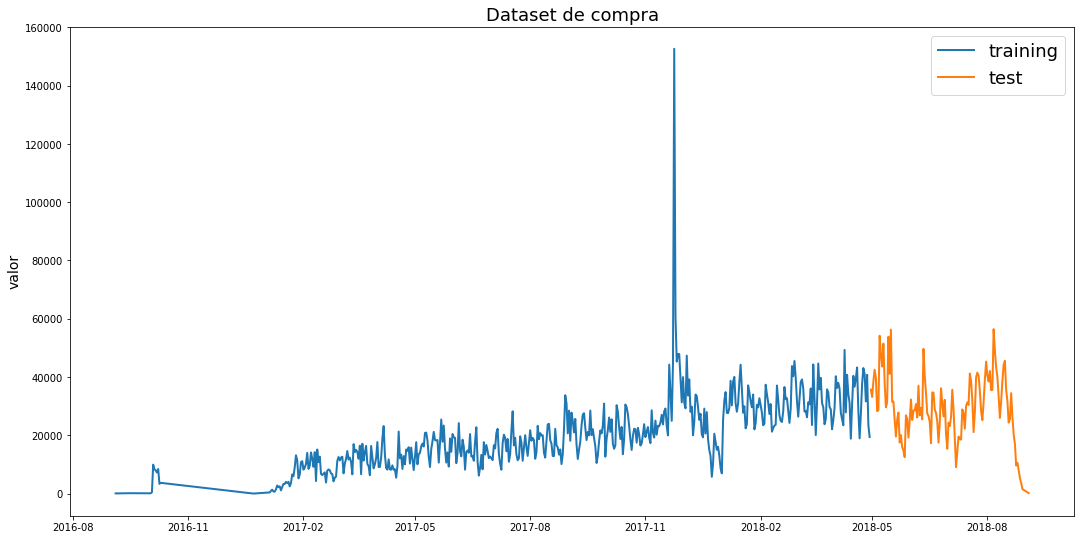

In [12]:
train, test = train_test_split(tabela_groupby_copy, test_size=0.2)

line_plot(train.valor, test.valor, 'training', 'test', 'Dataset de compra')

# Prepare data to the Model

In [13]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
test.head()

,valor
order_purchase_timestamp,
2018-04-30,35682.61
2018-05-01,33163.80
2018-05-02,38557.72
2018-05-03,42497.77
2018-05-04,39730.93


In [16]:
test.tail()

,valor
order_purchase_timestamp,
2018-08-26,8070.71
2018-08-27,5345.91
2018-08-28,3673.91
2018-08-29,1546.04
2018-09-03,145.00


In [17]:
train.head()

,valor
order_purchase_timestamp,
2016-09-04,72.89
2016-09-05,59.50
2016-09-15,134.97
2016-10-02,100.00
2016-10-03,463.48


In [18]:
training_set = train.values
training_set = np.array(training_set).reshape((-1,1))
training_set = np.reshape(training_set, (len(training_set), 1))

test_set = test.values
test_set = np.array(test_set).reshape((-1,1))
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# Building the Model and Train

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


In [20]:
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________
Train on 492 samples, validate on 122 samples
Epoch 1/100
492/492 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 2/100
492/492 [==============================] - 0s 819us/step - loss: 0.0086 - val_loss: 0.0041
Epoch 3/100
492/492 [==============================] - 0s 804us/step - loss: 0.0086 - val_loss: 0.0038
Epoch 4/100
492/492 [==========================

# Plot Predictions

In [21]:
prediction = model.predict(X_test)

In [22]:
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [23]:
Y_test2_inverse_without_last = Y_test2_inverse[:-1]

In [24]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse_without_last, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 3191.947


In [25]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [26]:
Test_Dates = test.index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))

trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'With purchase date information to predict future sales',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'purchase value'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

# Future Sales

In [27]:
test.iloc[-1:]

,valor
order_purchase_timestamp,
2018-09-03,145.0


In [28]:
test_future = test

test_future['date'] = test.index
test_future = test_future[['date']]

for i in range(0, 29):
        aux = test_future.iloc[-1:]
        aux['date'] += pd.to_timedelta(1, unit='D')
        test_future = test_future.append(aux)

test_future = test_future.tail(30)
test_future['date'] = pd.to_datetime(test_future['date'])
test_future = test_future.groupby(['date']).sum()


In [29]:
test.valor.values[-2:]

array([1546.04,  145.  ])

In [30]:
look_back = 1
total_predictions = []
for i in range(0, 30):
    future_sales = []
    if i == 0:
        future_sales = test.valor.values[-2:]
    elif i == 1:
        future_sales.append(test.valor.values[-1:])
        future_sales.append(total_predictions[-1:])    
    elif i > 1:
        future_sales.append(total_predictions[-2:-1])
        future_sales.append(total_predictions[-1:])
    
    future_sales = np.array(future_sales).reshape((-1,1))
    future_sales = np.reshape(future_sales, (len(future_sales), 1))
    
    scaler = MinMaxScaler()
    future_sales = scaler.fit_transform(future_sales)
    
    X_test_future, Y_test_future = create_lookback(future_sales, look_back)
    
    X_test_future = np.reshape(X_test_future, (len(X_test_future), 1, X_test_future.shape[1]))
    
    prediction_future_sales = model.predict(X_test_future)
    
    prediction_inverse_future = scaler.inverse_transform(prediction_future_sales.reshape(-1, 1))
    prediction2_inverse_future = np.array(prediction_inverse_future[:,0])
    
    total_predictions.append(prediction2_inverse_future)

In [31]:
total_predictions = np.array(total_predictions).reshape(-1)
total_predictions.shape

(30,)

In [32]:
Test_future = test_future.index

trace2 = go.Scatter(x=Test_future, y=total_predictions, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace2]
layout = dict(title = 'With purchase date information to predict future sales',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'purchase value'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

# ARIMA Prediction

In [33]:
tabela_groupby_copy.head()

,valor
order_purchase_timestamp,
2016-09-04,72.89
2016-09-05,59.50
2016-09-15,134.97
2016-10-02,100.00
2016-10-03,463.48


In [34]:
y = tabela_groupby_copy

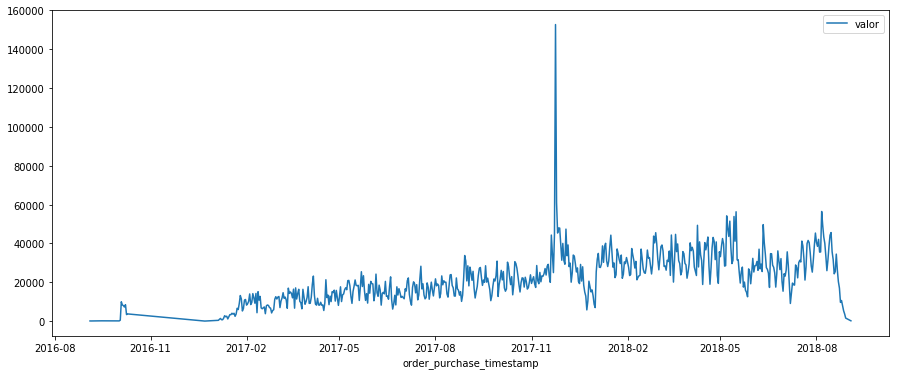

In [35]:
y.plot(figsize=(15, 6))
plt.show()

In [36]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

warnings.filterwarnings('ignore')

In [37]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3215      0.102      3.157      0.002       0.122       0.521
ma.L1         -0.8221      0.082     -9.994      0.000      -0.983      -0.661
ar.S.L12      -0.0668      0.101     -0.661      0.508      -0.265       0.131
ma.S.L12      -0.9858      0.038    -25.895      0.000      -1.060      -0.911
sigma2      1.384e+08   9.91e-10    1.4e+17      0.000    1.38e+08    1.38e+08


In [38]:
pred = results.get_prediction(start=0, dynamic=False)
pred_ci = pred.conf_int()

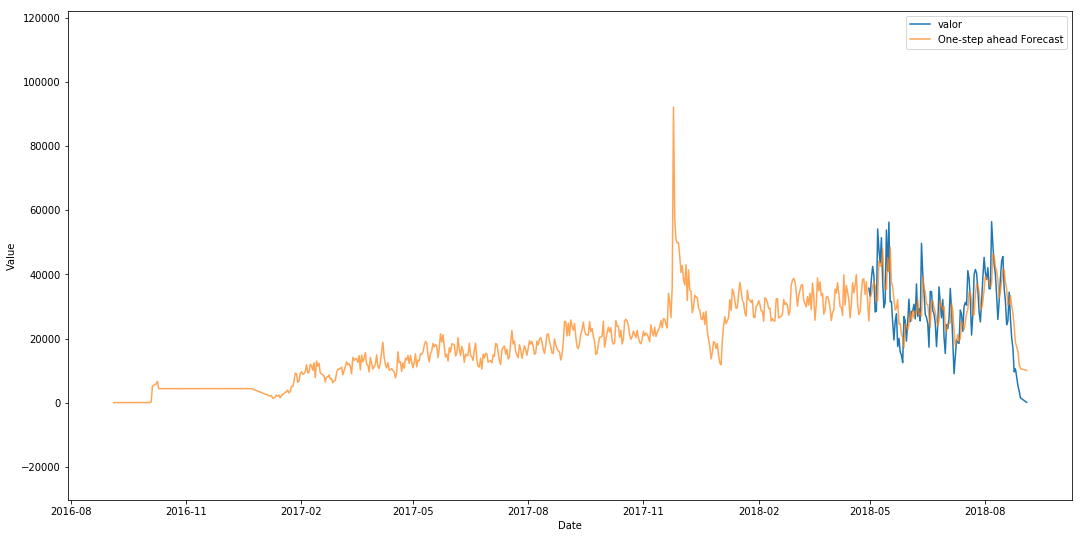

In [39]:
ax = y[493:].plot(label='observed', figsize=(18, 9))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='white', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

In [40]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [41]:
test_future = test

test_future['date'] = test.index
test_future = test_future[['date']]

for i in range(0, 100):
        aux = test_future.iloc[-1:]
        aux['date'] += pd.to_timedelta(1, unit='D')
        test_future = test_future.append(aux)

test_future = test_future.tail(100)
test_future['date'] = pd.to_datetime(test_future['date'])
test_future = test_future.groupby(['date']).sum()


In [42]:
trace2 = go.Scatter(x=test_future.index, y=pred_uc.predicted_mean.values, name='Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace2]
layout = dict(title = 'With purchase date information to predict future sales',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'purchase value'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')